<a href="https://colab.research.google.com/github/sanuthit/Risk-Based-Motor-Insurance-Premium-Calculation-System-/blob/Renewal-risk-model/Renewal_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATA_DIR = "/content/drive/MyDrive/Data/Datasets"
df = pd.read_csv(f"{DATA_DIR}/renewal_risk_score_dataset.csv")
display(df.head())

,customer_id,policy_id,policy_start_date,policy_expiry_date,renewal_date,total_claims,total_claim_amount,avg_claim_amount,max_claim_amount,major_claim_count,...,had_major_claim_last_1_year,years_since_last_claim,frequent_claimer_flag,high_long_term_frequency_flag,high_severity_claimer_flag,small_frequent_claims_flag,freq_score,sev_score,recency_score,risk_score
0,C000001,P000001,2023-09-09,2024-09-09,2024-09-09,2.0,513817.0,256908.5,441899.0,0.0,...,0.0,0.114990,0,0,0,0,0.5,0.866250,0.977264,7.72
1,C000002,P000002,2023-02-14,2024-02-14,2024-02-14,2.0,1826187.0,913093.5,1322535.0,1.0,...,1.0,0.342231,0,0,0,0,0.5,0.939303,0.933844,22.83
2,C000003,P000003,2023-09-12,2024-09-12,2024-09-12,2.0,4155749.0,2077874.5,2118271.0,2.0,...,1.0,0.772074,0,0,0,0,0.5,0.970694,0.856917,27.43
3,C000004,P000004,2024-10-09,2025-10-09,2025-10-09,2.0,196571.0,98285.5,118691.0,0.0,...,0.0,0.380561,0,0,0,0,0.5,0.778647,0.926712,5.82
4,C000005,P000005,2024-02-29,2025-02-28,2025-02-28,0.0,0.0,0.0,0.0,0.0,...,0.0,999.000000,0,0,0,0,0.0,0.000000,0.135335,0.00


In [6]:
target = "total_claim_amount_last_1_year"
y = pd.to_numeric(df[target], errors="coerce").fillna(0.0)

print("Target summary:")
display(y.describe())

Target summary:


,total_claim_amount_last_1_year
count,6.000000e+04
mean,1.575052e+06
std,1.834890e+06
min,0.000000e+00
25%,9.699150e+04
50%,6.428640e+05
75%,2.713310e+06
max,1.679628e+07


In [7]:
drop_cols = [
    "customer_id","policy_id","policy_start_date","policy_expiry_date","renewal_date",
    "last_claim_date","claim_id","claim_date","claim_type","claim_status"  # if they exist
]

feature_cols = [c for c in df.columns if c not in drop_cols + [target]]

X = df[feature_cols].copy()

# convert everything numeric where possible
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors="ignore")

# fill missing numeric
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print("Features:", len(feature_cols))
print("X shape:", X.shape)


Features: 21
X shape: (60000, 21)


/tmp/ipython-input-3083515381.py:12: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X[c] = pd.to_numeric(X[c], errors="ignore")


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (48000, 21) Test: (12000, 21)


# NGBOOST

In [9]:
!pip -q install ngboost

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 8.1 MB/s eta 0:00:00


In [10]:
from ngboost import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import LogScore

In [11]:
ngb = NGBRegressor(
    Dist=Normal,
    Score=LogScore,
    n_estimators=800,
    learning_rate=0.03,
    natural_gradient=True,
    random_state=42
)

ngb.fit(X_train, y_train)
print("Model trained")

[iter 0] loss=15.8431 val_loss=0.0000 scale=1.0000 norm=1485488.0265
[iter 100] loss=11.6425 val_loss=0.0000 scale=4.0000 norm=24995.2294
[iter 200] loss=9.7856 val_loss=0.0000 scale=2.0000 norm=11171.6325
[iter 300] loss=9.6508 val_loss=0.0000 scale=0.0000 norm=0.0013
[iter 400] loss=9.6508 val_loss=0.0000 scale=0.0000 norm=0.0013
[iter 500] loss=9.6508 val_loss=0.0000 scale=0.0000 norm=0.0013
[iter 600] loss=9.6508 val_loss=0.0000 scale=0.0000 norm=0.0013
[iter 700] loss=9.6508 val_loss=0.0000 scale=0.0000 norm=0.0013
Model trained


In [15]:
pred_dist = ngb.pred_dist(X_test)
pred_mean = pred_dist.mean()

In [18]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import numpy as np

# Predictions from NGBoost
pred_mean = ngb.predict(X_test)

# Core metrics
mae = mean_absolute_error(y_test, pred_mean)
mse = mean_squared_error(y_test, pred_mean)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_mean)

# Normalized RMSE (important for insurance)
nrmse = rmse / y_test.mean()

print("MAE  :", round(mae, 2))
print("RMSE :", round(rmse, 2))
print("R²   :", round(r2, 4))
print("NRMSE:", round(nrmse, 4))


MAE  : 6235.13
RMSE : 36644.23
R²   : 0.9996
NRMSE: 0.0234


In [20]:
y_test.describe()

,total_claim_amount_last_1_year
count,1.200000e+04
mean,1.565152e+06
std,1.822577e+06
min,0.000000e+00
25%,9.759175e+04
50%,6.320170e+05
75%,2.703909e+06
max,1.679628e+07


In [21]:
nrmse = rmse / y_test.mean()
print("NRMSE:", round(nrmse, 3))

NRMSE: 0.023


In [24]:
import pandas as pd

calib_df = pd.DataFrame({
    "predicted": pred_mean,
    "actual": y_test.values
})

# Create 10 equal-sized risk buckets
calib_df["risk_bucket"] = pd.qcut(
    calib_df["predicted"],
    q=10,
    duplicates="drop"
)


In [25]:
calibration_table = calib_df.groupby("risk_bucket").agg(
    mean_predicted=("predicted", "mean"),
    mean_actual=("actual", "mean"),
    count=("actual", "count")
).reset_index()

calibration_table


/tmp/ipython-input-2086627714.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration_table = calib_df.groupby("risk_bucket").agg(


,risk_bucket,mean_predicted,mean_actual,count
0,"(-122843.046, 201.337]",1.172904e+02,0.000000e+00,1464
1,"(201.337, 70958.881]",4.845394e+04,4.818388e+04,940
2,"(70958.881, 129667.86]",9.739428e+04,9.786115e+04,1198
3,"(129667.86, 350953.028]",2.307436e+05,2.301330e+05,1198
4,"(350953.028, 634453.474]",4.865305e+05,4.867078e+05,1201
5,"(634453.474, 1621510.705]",1.154779e+06,1.153050e+06,1199
6,"(1621510.705, 2345344.163]",1.986492e+06,1.986507e+06,1201
7,"(2345344.163, 3055331.973]",2.710275e+06,2.708667e+06,1200
8,"(3055331.973, 3888655.612]",3.392027e+06,3.390719e+06,1200
9,"(3888655.612, 15947080.312]",5.564940e+06,5.564218e+06,1199


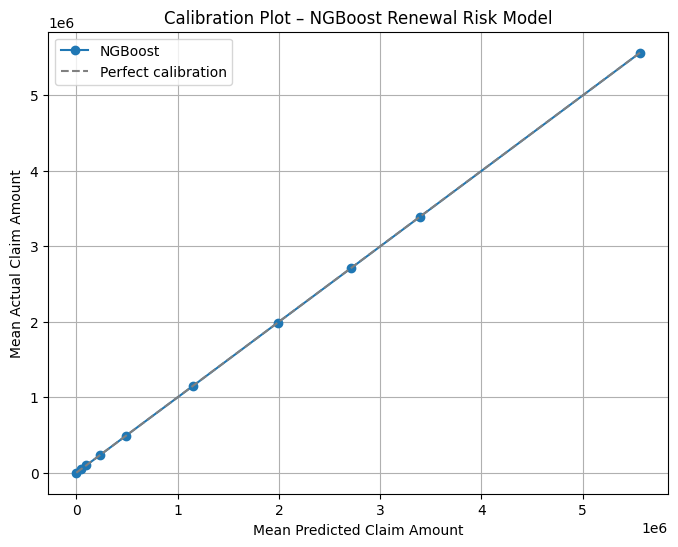

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

plt.plot(
    calibration_table["mean_predicted"],
    calibration_table["mean_actual"],
    marker="o",
    label="NGBoost"
)

# Perfect calibration reference line
min_val = min(calibration_table["mean_predicted"].min(),
              calibration_table["mean_actual"].min())
max_val = max(calibration_table["mean_predicted"].max(),
              calibration_table["mean_actual"].max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    "--",
    color="gray",
    label="Perfect calibration"
)

plt.xlabel("Mean Predicted Claim Amount")
plt.ylabel("Mean Actual Claim Amount")
plt.title("Calibration Plot – NGBoost Renewal Risk Model")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
calibration_error = (
    (calibration_table["mean_predicted"] -
     calibration_table["mean_actual"]).abs().mean()
)

print("Mean Calibration Error:", round(calibration_error, 2))

Mean Calibration Error: 702.4


# LightGBM Regressor

In [28]:
!pip install lightgbm


In [29]:
import pandas as pd
import numpy as np

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [30]:
DATA_PATH = "/content/drive/MyDrive/Data/Datasets/renewal_risk_score_dataset.csv"
df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head()


(60000, 28)


,customer_id,policy_id,policy_start_date,policy_expiry_date,renewal_date,total_claims,total_claim_amount,avg_claim_amount,max_claim_amount,major_claim_count,...,had_major_claim_last_1_year,years_since_last_claim,frequent_claimer_flag,high_long_term_frequency_flag,high_severity_claimer_flag,small_frequent_claims_flag,freq_score,sev_score,recency_score,risk_score
0,C000001,P000001,2023-09-09,2024-09-09,2024-09-09,2.0,513817.0,256908.5,441899.0,0.0,...,0.0,0.114990,0,0,0,0,0.5,0.866250,0.977264,7.72
1,C000002,P000002,2023-02-14,2024-02-14,2024-02-14,2.0,1826187.0,913093.5,1322535.0,1.0,...,1.0,0.342231,0,0,0,0,0.5,0.939303,0.933844,22.83
2,C000003,P000003,2023-09-12,2024-09-12,2024-09-12,2.0,4155749.0,2077874.5,2118271.0,2.0,...,1.0,0.772074,0,0,0,0,0.5,0.970694,0.856917,27.43
3,C000004,P000004,2024-10-09,2025-10-09,2025-10-09,2.0,196571.0,98285.5,118691.0,0.0,...,0.0,0.380561,0,0,0,0,0.5,0.778647,0.926712,5.82
4,C000005,P000005,2024-02-29,2025-02-28,2025-02-28,0.0,0.0,0.0,0.0,0.0,...,0.0,999.000000,0,0,0,0,0.0,0.000000,0.135335,0.00


In [31]:
FEATURES = [
    "claims_last_1_year",
    "claims_last_3_years",
    "total_claim_amount_last_1_year",
    "largest_claim_amount_last_1_year",
    "years_since_last_claim",
    "frequent_claimer_flag",
    "high_severity_claimer_flag",
    "small_frequent_claims_flag",
    "had_major_claim_last_1_year"
]

TARGET = "total_claim_amount_last_1_year"

X = df[FEATURES]
y = df[TARGET]


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)


In [33]:
lgb_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 45000, number of used features: 9
[LightGBM] [Info] Start training from score 1578451.891511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
              n_estimators=500, random_state=42, subsample=0.8)

In [34]:
y_pred = lgb_model.predict(X_test)


In [35]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
nrmse = rmse / y_test.mean()

print("LightGBM Performance")
print("--------------------")
print(f"MAE   : {mae:,.2f}")
print(f"RMSE  : {rmse:,.2f}")
print(f"R²    : {r2:.4f}")
print(f"NRMSE : {nrmse:.4f}")


LightGBM Performance
--------------------
MAE   : 13,746.83
RMSE  : 99,463.74
R²    : 0.9970
NRMSE : 0.0636


In [36]:
df_eval = pd.DataFrame({
    "actual": y_test,
    "predicted": y_pred
})

df_eval["decile"] = pd.qcut(df_eval["predicted"], 10, duplicates="drop")

calibration = df_eval.groupby("decile")[["actual", "predicted"]].mean()

calibration


/tmp/ipython-input-3669158880.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_eval.groupby("decile")[["actual", "predicted"]].mean()


,actual,predicted
decile,,
"(245.013, 72268.568]",1.932115e+04,1.950552e+04
"(72268.568, 134489.225]",9.900298e+04,9.863838e+04
"(134489.225, 359350.031]",2.336101e+05,2.338745e+05
"(359350.031, 628882.851]",4.883170e+05,4.882270e+05
"(628882.851, 1617149.81]",1.149967e+06,1.149648e+06
"(1617149.81, 2352525.927]",1.996421e+06,1.996137e+06
"(2352525.927, 3053879.834]",2.711250e+06,2.710906e+06
"(3053879.834, 3860611.614]",3.380991e+06,3.380579e+06
"(3860611.614, 12017419.929]",5.553560e+06,5.548586e+06
